<a href="https://colab.research.google.com/github/anoopmanikantas/Time-Series-analysis-of-Satellite-data-Feature-extractions-on-Transitions/blob/main/Satellite_Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required libraries

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

Connect to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract dataset

In [ ]:
!unzip /content/drive/MyDrive/SATimgData/archive.zip

Constants


In [4]:
MAIN_DIR = '/content/'

In [5]:
df = pd.read_csv(MAIN_DIR+'EuroSATallBands/train.csv')
df.head()

,Filename,Label,ClassName
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop
2,HerbaceousVegetation/HerbaceousVegetation_1025...,2,HerbaceousVegetation
3,SeaLake/SeaLake_1439.tif,9,SeaLake
4,River/River_1052.tif,8,River


Everything below is waste (under maintenance)

In [9]:
def min_max(img):
  mn = img.min()
  mx = img.max()
  return (img-mn)/(mx-mn)

In [16]:
img = tiff.imread(MAIN_DIR+'EuroSATallBands/Pasture/Pasture_1.tif')[:,:,1:4][:,:,::-1]
img_m = img.astype('float32')
img_m/=4095
img_min_max = min_max(img_m)

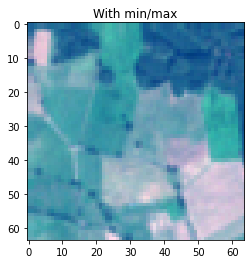

In [17]:
plt.imshow(img_min_max)
plt.title("With min/max")
plt.show()

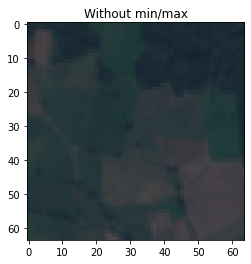

In [18]:
plt.imshow(img_m)
plt.title("Without min/max")
plt.show()

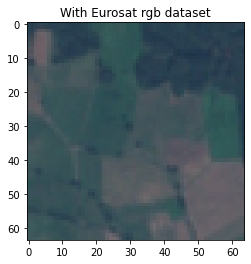

In [19]:
img = Image.open(MAIN_DIR+'EuroSAT/Pasture/Pasture_1.jpg')
plt.title("With Eurosat rgb dataset")
plt.imshow(img)